## GP_Sampler


Created by: Juan Felipe Osorio Ramirez

Department of Applied Mathematics, University of Washington
***

In [ ]:
import jax.numpy as jnp
from jax import grad, vmap, jit
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel

data

In [ ]:
N = 100
np.random.seed(2023)
mini = [0,0]
maxi = [1,1]

x_train = jnp.array(np.random.uniform(low=mini, high=maxi, size=(N,2)))
x_test = jnp.array(np.random.uniform(low=mini, high=maxi, size=(N//2,2)))

function with two arguments

In [ ]:
def u1(x,y,k):
  return x*y + k*x
# True grad
def u_dot_true(x,y,k):
  return y + k
# Auto grad evaluated at T
def u_dot(u, T, params, arg):
  u_Dot = jit(grad(u,arg))
  return vmap(lambda t: u_Dot(t[0],t[1],params))(T)

In [ ]:
def Gaussian2D(x1,x2,y1,y2,params):
	sigma = params
	r2 = ((x1-y1)**2 + (x2-y2)**2)
	return jnp.exp(-r2/(2*sigma**2))

# K
def K_2D(kernel, T,T_, params):
	K = jit(kernel)
	return vmap(lambda t: vmap(lambda t_: K(t[0],t[1], t_[0],t_[1], params))(T_))(T)


# D^1 K
def K_dot2D(kernel, T ,T_, params, arg):
	K_Dot = jit(grad(kernel,arg))
	return vmap(lambda t: vmap(lambda t_: K_Dot(t[0],t[1], t_[0],t_[1], params))(T_))(T)

# D^2 K
def K_ddot2D(kernel, T ,T_, params, arg1, arg2):
	K_Dot = jit(grad(grad(kernel,arg1),arg2))
	return vmap(lambda t: vmap(lambda t_: K_Dot(t[0],t[1], t_[0],t_[1], params))(T_))(T)

# D^3 K
def K_dddot2D(kernel, T ,T_, params, arg1, arg2, arg3):
	K_Dot = jit(grad(grad(grad(kernel,arg1),arg2),arg3))
	return vmap(lambda t: vmap(lambda t_: K_Dot(t[0],t[1], t_[0],t_[1], params))(T_))(T)

# D^4 K
def K_ddddot2D(kernel, T ,T_, params, arg1, arg2, arg3, arg4):
	K_Dot = jit(grad(grad(grad(grad(kernel,arg1),arg2),arg3),arg4))
	return vmap(lambda t: vmap(lambda t_: K_Dot(t[0],t[1], t_[0],t_[1], params))(T_))(T)



$$u(x_1,x_2) = \sum_{j=1}^N \alpha_j K\left(x_1,x_2,x_{1j},x_{2j}\right)$$

$$\partial_{x_1}u(x_1,x_2) = \sum_{j=1}^N \alpha_j \partial_{x_1}K\left(x_1,x_2,x_{1j},x_{2j}\right)$$


In [ ]:
G = K_2D(Gaussian2D, x_test, x_train,1)
G.shape

(50, 100)

In [ ]:
import numpy as np
import jax.numpy as jnp
from jax import grad, jacfwd, vmap, jit
import matplotlib.pyplot as plt


def Gaussian(t,t_,params):
	sigma = params
	r2 = jnp.dot(t-t_,t-t_)
	return jnp.exp(-r2/(2*sigma**2))

def K(kernel, T, T_, params):
	return vmap(lambda t: vmap(lambda t_: kernel(t,t_, params))(T_))(T)

xtrain = np.linspace(0,1,100)

In [ ]:
class GPs():
  '''
  kernel : Covariance function of the GP.
  X: Collocation points.
  '''

  def __init__(self, kernel, kparams, reg,  X, seed, nsamples):
    self.kernel = kernel
    self.X = X
    self.kparams = kparams
    self.reg = reg
    self.N = len(X)
    self.seed = seed
    self.nsamples = nsamples
    self.kernelmat = self.kernel_matrix()
    self.choleskyfactor = self.chol_factor()
    self.normalsample = self.normal_samples()
    self.sample = self.get_sample()

  def kernel_matrix(self):
    return K(self.kernel,self.X,self.X,self.kparams) + self.reg*np.eye(self.N)

  def normal_samples(self):
    np.random.seed(self.seed)
    return np.random.normal(0, 1, (self.N,self.nsamples))

  def chol_factor(self):
    return np.linalg.cholesky(self.kernelmat)

  def get_sample(self):
    return np.dot(self.choleskyfactor,self.normalsample)



In [ ]:
mygp = GPs(Gaussian, 0.3, 1e-6, xtrain, 2023, 5)

In [ ]:
mygp.sample.shape

(100, 5)

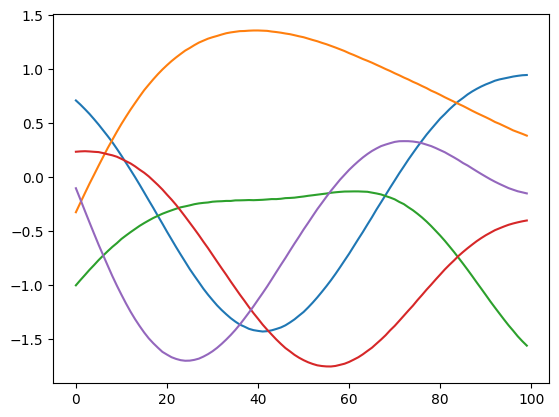

In [ ]:
for i in range(5):
  plt.plot(mygp.sample[:,i])

In [ ]:
from jax._src.lax.lax import zeros_like_shaped_array
def GPsampler(kernel, kparams, reg,  X, seed, nsamples):
  '''
  kernel: Covariance function.
  kparams: List of parameters of kernel.
  reg: Regularization for kernel matrix.
  X: Domain to get the sample.
  seed: Seed to reproduce the experiment.
  nsamples: Number of samples.
  '''
  N = len(X)
  # Kernel matrix
  G = K(kernel, X, X, kparams) + reg*np.eye(N)
  # Cholesky factor
  L = np.linalg.cholesky(G)
  # Normal samples
  np.random.seed(seed)
  Z = np.random.normal(0, 1, (N,nsamples))
  # L*Z
  sample = np.dot(L,Z)
  return sample

In [ ]:
out = GPsampler(Gaussian, 0.3, 1e-6, xtrain, 2023, 5)

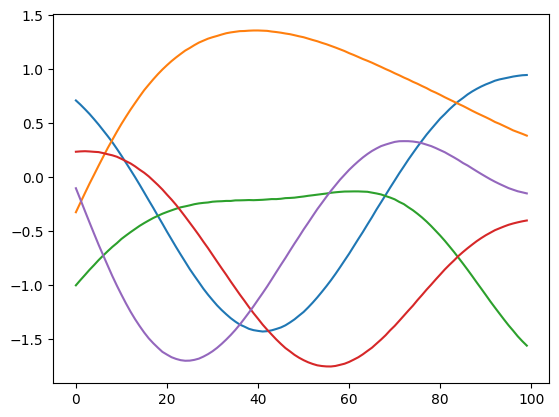

In [ ]:
for i in range(5):
  plt.plot(out[:,i])